<a href="https://colab.research.google.com/github/farhanwew/Digital-Image-processing/blob/main/Segmentatio_Based_on_Clustering_and_Watershed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Segmentasi Citra Berbasis Similaritas: Clustering dan Watershed**

---

### 1. Konsep Segmentasi Berbasis Clustering

Segmentasi berbasis clustering memanfaatkan algoritma pembelajaran tak terawasi (unsupervised learning) untuk mengelompokkan piksel berdasarkan fitur seperti intensitas, warna, atau koordinat spasial.

Algoritma yang umum digunakan:

* **K-Means Clustering**: Mengelompokkan piksel ke dalam *k* klaster berdasarkan jarak ke pusat klaster.
* **Mean Shift**, **DBSCAN**, dan lain-lain.

### 2. Implementasi K-Means Clustering

```python
  import cv2
  import numpy as np
  import matplotlib.pyplot as plt

  img = cv2.imread('image.jpg')
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_rgb)
  plt.title('RGB Original Image')
  plt.axis('off')
  plt.show()

  Z = img_rgb.reshape((-1,3))
  Z = np.float32(Z)

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 3
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

  center = np.uint8(center)
  res = center[label.flatten()]
  segmented_img = res.reshape((img.shape))

  plt.imshow(segmented_img)
  plt.title('K-Means Segmentation')
  plt.axis('off')
  plt.show()
```

### 3. Konsep Segmentasi Watershed

Watershed adalah algoritma berbasis morfologi yang memodelkan citra sebagai topografi. Area terang (intensitas tinggi) dianggap sebagai puncak dan area gelap (intensitas rendah) sebagai lembah. Tujuannya adalah membanjiri lembah dari marker (penanda), lalu membuat batas di titik pertemuan antara banjir.
Watershed efektif jika dikombinasikan dengan marker dan preprocessing.

### 4. Implementasi Watershed di Python

```python
  img = cv2.imread('image.jpg')
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  # Noise removal
  kernel = np.ones((3,3), np.uint8)
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

  # Sure background
  sure_bg = cv2.dilate(opening, kernel, iterations=3)

  # Sure foreground
  dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
  ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

  # Unknown region
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg, sure_fg)

  # Marker labelling
  ret, markers = cv2.connectedComponents(sure_fg)
  markers = markers + 1
  markers[unknown == 255] = 0

  markers = cv2.watershed(img, markers)
  img[markers == -1] = [255, 0, 0]

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title('Watershed Result')
  plt.axis('off')
  plt.show()
```

---

### 5. Visualisasi Eksperimen Tambahan

#### Menguji jumlah klaster *K* yang berbeda pada K-Means:
```python
  for k in [2, 4, 6]:
      _, labels, centers = cv2.kmeans(np.float32(img_reshaped), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
      segmented_img = centers[labels.flatten()].reshape(img.shape).astype(np.uint8)
      plt.figure()
      plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
      plt.title(f'K-Means with k={k}')
      plt.axis('off')
      plt.show()
```

#### Menambahkan Preprocessing dengan CLAHE untuk Watershed:
```python
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  gray_clahe = clahe.apply(gray)
  # Gunakan gray_clahe dalam preprocessing untuk Watershed
```

#### Menggabungkan Watershed dengan Deteksi Tepi dan Thresholding untuk Marker Lebih Akurat:
```python
  edges = cv2.Canny(gray, 100, 200)
  edges_dilated = cv2.dilate(edges, kernel, iterations=1)
  ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  combined_marker = cv2.bitwise_or(edges_dilated, thresh)
  # Lanjutkan dengan langkah marker dan watershed seperti sebelumnya
  # Gunakan 'combined_marker' sebagai referensi untuk sure_fg
```

#### Mengkombinasikan Clustering dan Watershed untuk Segmentasi Lebih Akurat:
Gabungan clustering (misalnya K-Means) dan watershed dapat meningkatkan akurasi segmentasi.
* Gunakan hasil clustering sebagai dasar penentuan marker.
* Terapkan watershed berdasarkan hasil threshold dari cluster tertentu atau perbedaan antar cluster.

```python
  # Asumsikan segmented_img dari K-Means telah tersedia
  gray_clustered = cv2.cvtColor(segmented_img, cv2.COLOR_RGB2GRAY)
  ret, thresh_clustered = cv2.threshold(gray_clustered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Preprocessing untuk marker
  opening = cv2.morphologyEx(thresh_clustered, cv2.MORPH_OPEN, kernel, iterations=2)
  sure_bg = cv2.dilate(opening, kernel, iterations=3)
  dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
  ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg, sure_fg)

  ret, markers = cv2.connectedComponents(sure_fg)
  markers = markers + 1
  markers[unknown == 255] = 0

  markers = cv2.watershed(img, markers)
  img[markers == -1] = [255, 0, 0]

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title('Clustering + Watershed')
  plt.axis('off')
  plt.show()
```

---

### 6. Kesimpulan

* Segmentasi berbasis clustering efektif untuk pemisahan objek berdasarkan kesamaan warna/intensitas (tekstur homogen), sementara watershed sangat baik untuk segmentasi objek bersentuhan (objek dengan batas yang jelas).
* Eksperimen parameter penting untuk mendapatkan hasil segmentasi terbaik.
* Preprocessing seperti CLAHE, serta deteksi tepi dan thresholding sangat membantu dalam memperjelas batas objek.
* Kombinasikan Clustering dan Watershed dapat menghasilkan segmentasi yang lebih akurat.

# Load data

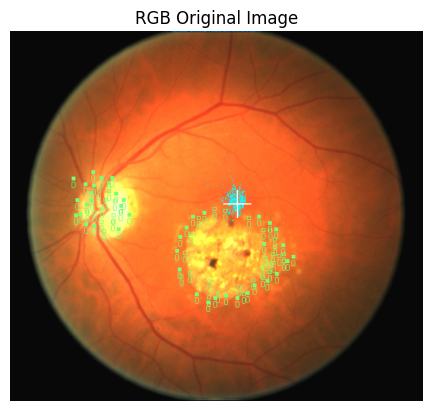

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('/content/retinal image proc.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('RGB Original Image')
plt.axis('off')
plt.show()

# Clustering

## Kmeans

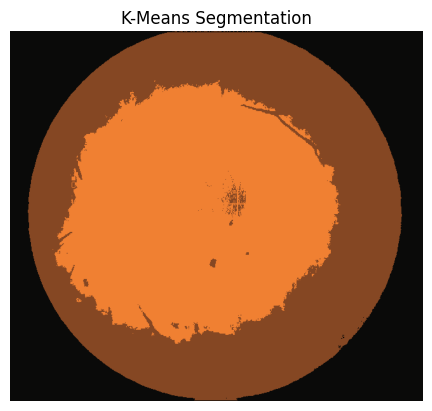

In [2]:
Z = img_rgb.reshape((-1,3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
segmented_img = res.reshape((img.shape))

plt.imshow(segmented_img)
plt.title('K-Means Segmentation')
plt.axis('off')
plt.show()

### Experimet K

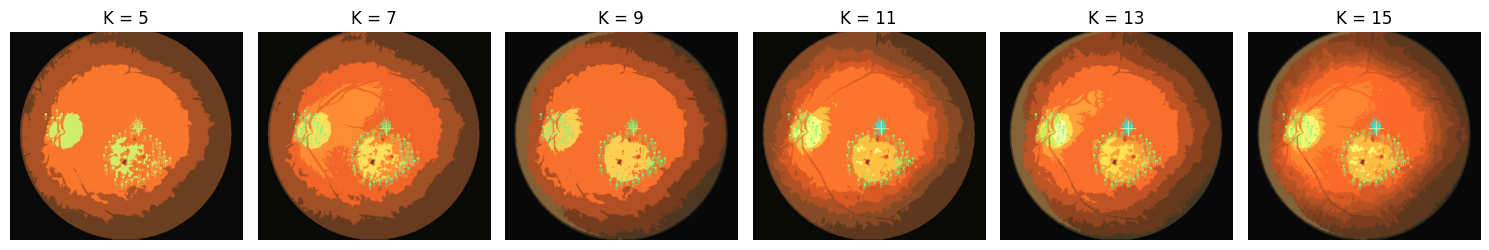

In [3]:
def kmeans_segmentation_experiment(img, cluster_values):
    """
    Perform K-Means segmentation with various cluster values and display the results in a subplot.

    Parameters:
        img (numpy.ndarray): Input image (must be in grayscale or color).
        cluster_values (list of int): List of K values (number of clusters) to experiment with.
    """
    # Reshape the image into a 2D array of pixels
    Z = img.reshape((-1, 3)) if len(img.shape) == 3 else img.reshape((-1, 1))
    Z = np.float32(Z)

    # Define criteria for K-Means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # Prepare the plot
    plt.figure(figsize=(15, 5))
    for i, K in enumerate(cluster_values, start=1):
        # Apply K-Means clustering
        ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert the centers back to uint8
        center = np.uint8(center)

        # Create the segmented image
        res = center[label.flatten()]
        segmented_img = res.reshape(img.shape)

        # Add the segmented image to the subplot
        plt.subplot(1, len(cluster_values), i)
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else segmented_img, cmap='gray')
        plt.title(f'K = {K}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



# Define cluster values to experiment with
cluster_values = list(range(5, 16, 2))

# Perform K-Means segmentation experiment
kmeans_segmentation_experiment(img, cluster_values)

## Mean shift

In [4]:
from sklearn.cluster import MeanShift, DBSCAN
def clustering_experiment(img, method="mean_shift", bandwidth=None, eps=5, min_samples=5):
    """
    Apply clustering (Mean Shift or DBSCAN) on an image and visualize the results.

    Parameters:
        img (numpy.ndarray): Input image in grayscale or color.
        method (str): Clustering method ("mean_shift" or "dbscan").
        bandwidth (float): Bandwidth for Mean Shift (ignored for DBSCAN).
        eps (float): Maximum distance between two samples for DBSCAN.
        min_samples (int): Minimum number of samples for DBSCAN.
    """
    # Reshape the image to a 2D feature space
    Z = img.reshape((-1, 3)) if len(img.shape) == 3 else img.reshape((-1, 1))

    if method == "mean_shift":
        # Apply Mean Shift clustering
        mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels = mean_shift.fit_predict(Z)
        centers = mean_shift.cluster_centers_
        print(f"Number of clusters (Mean Shift): {len(centers)}")
    elif method == "dbscan":
        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(Z)
        print(f"Number of clusters (DBSCAN): {len(set(labels)) - (1 if -1 in labels else 0)}")
    else:
        raise ValueError("Invalid method. Use 'mean_shift' or 'dbscan'.")

    # Map the cluster labels back to the image
    unique_labels = np.unique(labels)
    segmented_img = np.zeros_like(Z, dtype=np.uint8)

    for label in unique_labels:
        if label == -1:  # Noise
            continue
        mask = (labels == label)
        segmented_img[mask] = np.random.randint(0, 255, size=Z.shape[1], dtype=np.uint8)

    segmented_img = segmented_img.reshape(img.shape)

    # Visualize the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(segmented_img, cmap='gray')
    plt.title(f"Segmented ({method})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Number of clusters (Mean Shift): 17


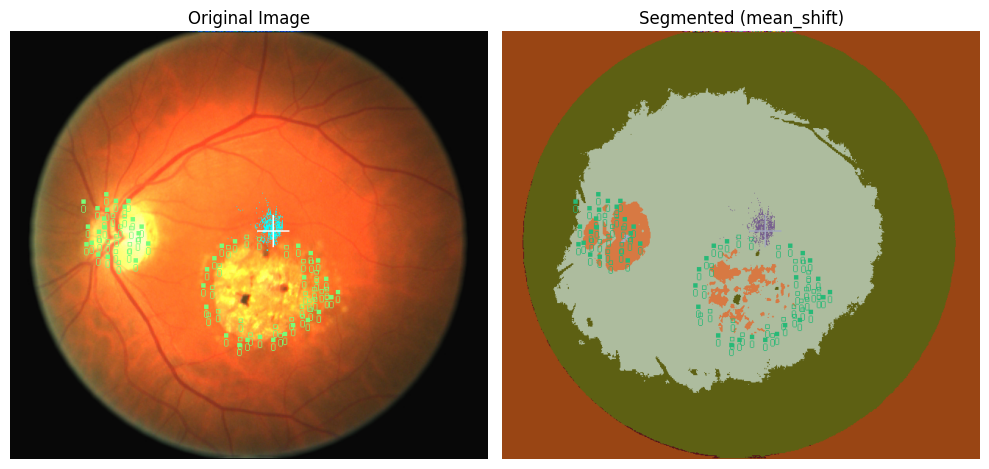

In [5]:
# Experiment with Mean Shift
clustering_experiment(img, method="mean_shift", bandwidth=30)

#  Watershed

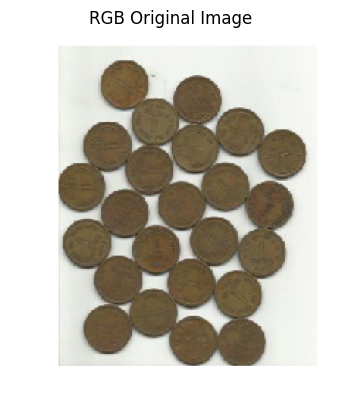

In [13]:
img = cv2.imread('/content/coin.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('RGB Original Image')
plt.axis('off')
plt.show()

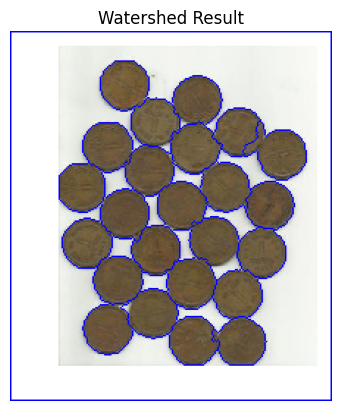

In [14]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Watershed Result')
plt.axis('off')
plt.show()

## Preprocessing dengan CLAHE untuk Watershed

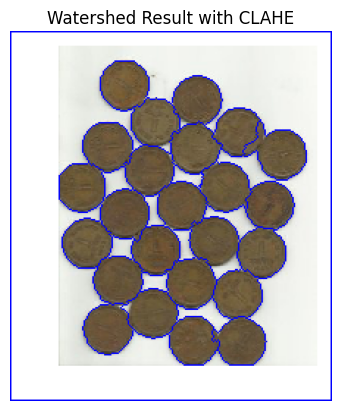

In [11]:
# Konversi ke grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Menambahkan preprocessing dengan CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_clahe = clahe.apply(gray)

# Thresholding
ret, thresh = cv2.threshold(gray_clahe, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

# Menampilkan hasil
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Watershed Result with CLAHE')
plt.axis('off')
plt.show()

## Watershed dengan Deteksi Tepi dan Thresholding

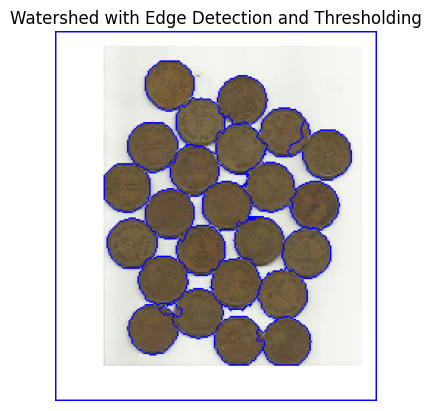

In [12]:
# Konversi ke grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Deteksi tepi menggunakan Canny
edges = cv2.Canny(gray, 100, 200)

# Dilasi pada hasil deteksi tepi
kernel = np.ones((3, 3), np.uint8)
edges_dilated = cv2.dilate(edges, kernel, iterations=1)

# Thresholding
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Menggabungkan hasil deteksi tepi dan thresholding
combined_marker = cv2.bitwise_or(edges_dilated, thresh)

# Noise removal
opening = cv2.morphologyEx(combined_marker, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground menggunakan marker gabungan
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

# Menampilkan hasil
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Watershed with Edge Detection and Thresholding')
plt.axis('off')
plt.show()

# Clustering dan Watershed untuk Segmentasi

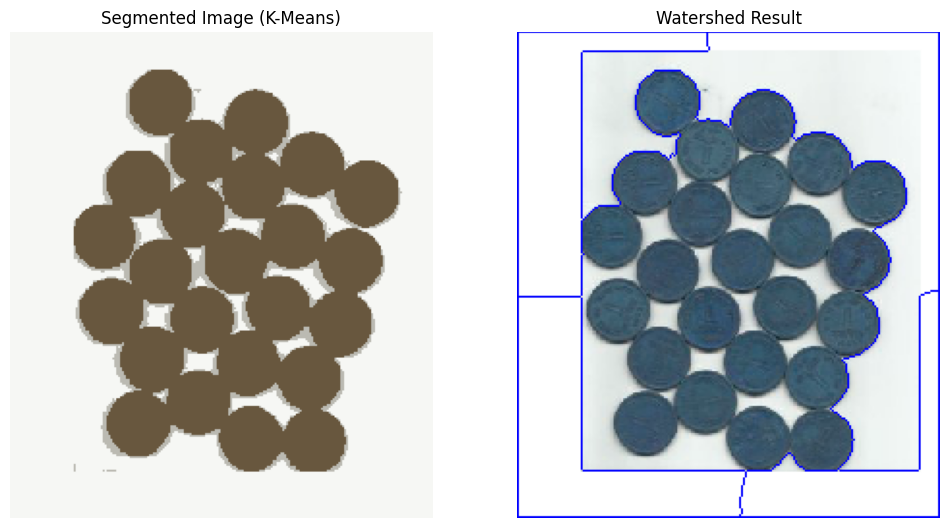

In [15]:
img = cv2.imread('/content/coin.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah format ke RGB untuk visualisasi yang lebih baik

# Ubah gambar ke bentuk 2D array untuk K-Means
pixel_values = img.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# K-Means parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3  # Jumlah kluster
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Konversi pusat klaster ke nilai uint8
centers = np.uint8(centers)
segmented_img = centers[labels.flatten()]  # Ganti nilai piksel dengan pusat klaster
segmented_img = segmented_img.reshape(img.shape)

# Konversi gambar hasil K-Means ke grayscale
gray_clustered = cv2.cvtColor(segmented_img, cv2.COLOR_RGB2GRAY)

# Thresholding pada gambar hasil K-Means
ret, thresh_clustered = cv2.threshold(gray_clustered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Preprocessing untuk marker
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh_clustered, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

# Menampilkan hasil
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(segmented_img)
plt.title('Segmented Image (K-Means)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Watershed Result')
plt.axis('off')

plt.show()